In [141]:
!echo "Last updated: `date`"

Last updated: Fri Aug 14 20:02:07 PDT 2020


## [GP for binary classification (in STAN)][1]

$$
\begin{eqnarray}
y_n \mid p_i &\sim& \text{Bernoulli}(p_n), \text{ for } n=1,\dots, N \\
\text{logit}(\mathbf{p}) &\sim& \text{MvNormal}(0, K) \\
\alpha &\sim& \text{LogNormal}(0, 1) \\
\rho &\sim& \text{LogNormal}(0, 1) \\
\end{eqnarray}
%
$$

Try:
- adding a mean?

Note: 
- $\mathbf{K}$ is an $N\times N$ covariance matrix
  $K_{n,m} = \exp\left(-{\left\lVert\mathbf{x}_n - \mathbf{x}_m\right\rVert}^2_2\big/\rho^{2}\right)$.
- $\mathbf{x}_n$ are observed (possibly multivariate) spatial locations.

[1]: https://mc-stan.org/docs/2_24/stan-users-guide/fit-gp-section.html

In [142]:
# Load libraries.
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import pystan
from tqdm import trange
from scipy.spatial import distance_matrix
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

import sys
sys.path.append('../util')
from pystan_vb_extract import pystan_vb_extract

*** 
Below are some helpers for plotting and generating data / grids.

In [143]:
def gen_grid(X, n, return_each=False, eps=0):
    x0, x1 = np.meshgrid(np.linspace(X[:, 0].min()-eps, X[:, 0].max()+eps, n),
                         np.linspace(X[:, 1].min()-eps, X[:, 1].max()+eps, n))
    
    Y = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    
    if return_each:
        return Y, x0, x1
    else:
        return Y

In [144]:
def plot_data(X, y, edgecolors=None):
    colors = np.array(['blue', 'red'])
    plt.scatter(X[:, 0], X[:, 1], color=colors[y], edgecolors=edgecolors)

In [145]:
# Data dictionary.
def create_stan_data(X, y, m_rho=0, s_rho=1, m_alpha=0, s_alpha=1, eps=1e-6):
    N, P = X.shape
    assert (N, ) == y.shape
    
    return dict(y=y, X=X, N=N, P=P,
                m_rho=m_rho, s_rho=s_rho,
                m_alpha=m_alpha, s_alpha=s_alpha, eps=eps)

In [146]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def gp_predict(X, Xnew, samples, i, eps=1e-6):
    kernel = samples['alpha'][i]**2 * RBF(samples['rho'][i]) + eps*WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=0)
    gpr.fit(X, samples['f'][i, :])
    return sigmoid(gpr.predict(Xnew))

def plot_uq(samples, X, y, nnew, algo, eps=0.2, 
            figsize1=(8, 3), figsize2=(8, 3),
            color_res=100, color_res_sd=100, return_stuff=False,
            data_edgecolors='gold', vmin_sd=0, vmax_sd=None,
            kernel_params=['alpha', 'rho', 'beta']):
    
    nsamples = samples['alpha'].shape[0]
    
    nnew_rows = int(np.floor(np.sqrt(nnew)))
    Xnew, x0, x1 = gen_grid(X, nnew_rows, return_each=True, eps=eps)
    preds = np.stack([gp_predict(X, Xnew, samples, i) for i in trange(nsamples)]) 
    
    plt.figure(figsize=figsize1)
    
    # Plot mean function.
    plt.subplot(1, 2, 1)
    plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape),
                 color_res, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.colorbar();
    plot_data(X, y, edgecolors=data_edgecolors);
    plt.xticks([]); plt.yticks([]);
    plt.title("Posterior Mean Function ({})".format(algo))
    
    # Plot function sd.
    plt.subplot(1, 2, 2)
    plt.contourf(x0, x1, preds.std(0).reshape(x0.shape),
                 color_res_sd, cmap=plt.get_cmap('Oranges'),
                 vmin=vmin_sd, vmax=vmax_sd)
    plt.colorbar();
    plot_data(X, y, edgecolors='black');
    plt.xticks([]);
    plt.yticks([]);    
    plt.title("Posterior SD Function ({})".format(algo))
    plt.tight_layout()
    
    # Plot kernel parameters.
    plt.figure(figsize=figsize2)
    for i in range(3):
        param = kernel_params[i]
        plt.subplot(1, 3, i+1)
        plt.hist(samples[param], bins=30, density=True);
        plt.title('Histogram of {}'.format(param))
    plt.tight_layout()

***

In [147]:
# Set random seed for reproducibility.
np.random.seed(1)

In [148]:
# Process convolution model.
model_code = """
data {
  int<lower=0> N;
  int<lower=0> P;
  int<lower=0, upper=1> y[N];
  matrix[N, P] X;
  real m_rho;
  real<lower=0> s_rho;
  real m_alpha;
  real<lower=0> s_alpha;
  real<lower=0> eps;
}

parameters {
  real<lower=0> rho;   // range parameter in GP covariance fn
  real<lower=0> alpha; // covariance scale parameter in GP covariance fn
  vector[N] eta;
  real beta;
}

transformed parameters {
  vector[N] f;
  {
    matrix[N, N] K;   // GP covariance matrix
    matrix[N, N] LK;  // cholesky of GP covariance matrix
    row_vector[N] row_x[N];
    
    // Using exponential quadratic covariance function
    for (n in 1:N) {
      row_x[n] = to_row_vector(X[n, :]);
    }
    K = cov_exp_quad(row_x, alpha, rho); 

    // Add small values along diagonal elements for numerical stability.
    for (n in 1:N) {
        K[n, n] = K[n, n] + eps;
    }

    // Cholesky of K (lower triangle).  
    LK = cholesky_decompose(K); 
  
    f = LK * eta;
  }
}

model {
  // Priors.
  alpha ~ lognormal(m_alpha, s_alpha);
  rho ~ lognormal(m_rho, s_rho);
  eta ~ std_normal();
  beta ~ std_normal();
 
  // Model.
  y ~ bernoulli_logit(beta + f);
}
"""

In [149]:
# Compile model. This takes about a minute.
%time sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f3f15ebdf199b89422e925a69ba6a344 NOW.


CPU times: user 972 ms, sys: 38.2 ms, total: 1.01 s
Wall time: 56 s


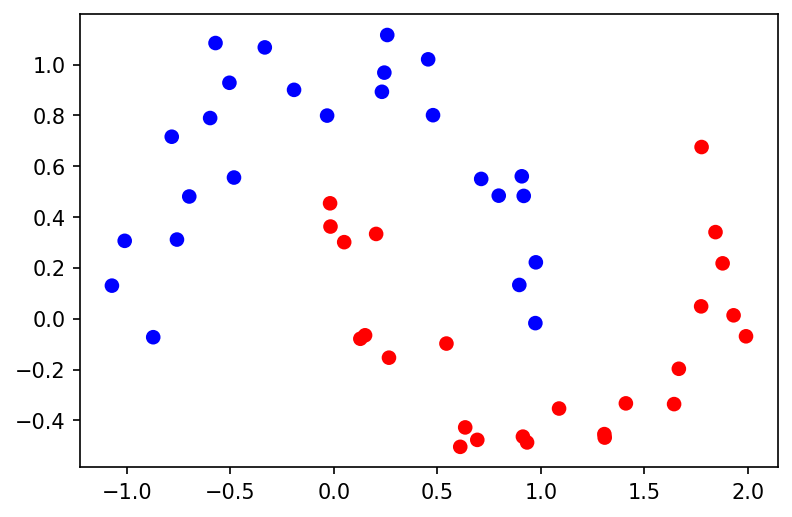

In [150]:
# Read data.
path_to_data = '../data/gp-binary-data-N50.json'
simdata = json.load(open(path_to_data))

# Store data.
X = np.stack([simdata['x1'], simdata['x2']], axis=-1)
y = np.array(simdata['y'])

# Plot data.
plot_data(X, y)

In [151]:
# Generate stan data dictionary.
stan_data = create_stan_data(X, y)

In [152]:
# Fit via ADVI.
%time vb_fit = sm.vb(data=stan_data, iter=1000, seed=1, grad_samples=1, elbo_samples=1)
vb_samples = pystan_vb_extract(vb_fit)

CPU times: user 392 ms, sys: 2.79 ms, total: 394 ms
Wall time: 393 ms


100%|██████████| 1000/1000 [00:05<00:00, 171.65it/s]


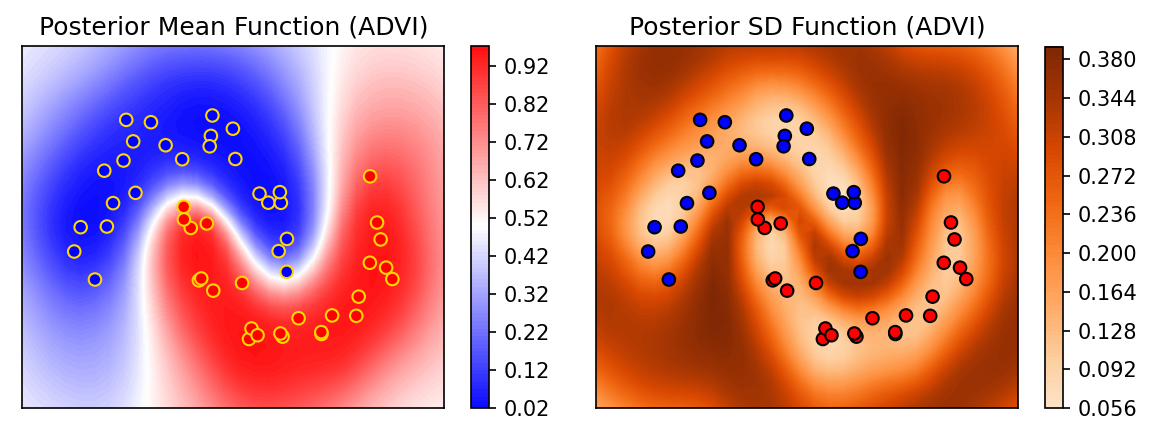

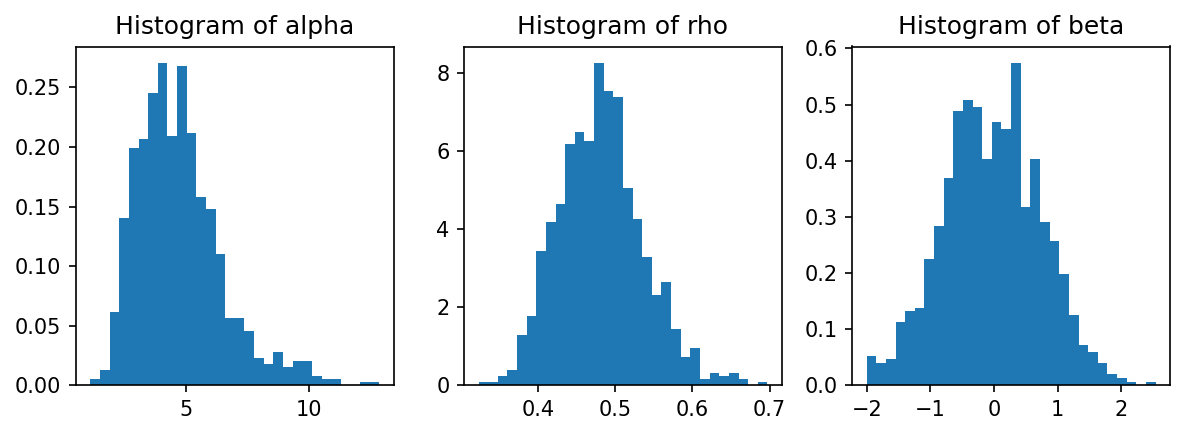

In [153]:
plot_uq(vb_samples, X, y, 500, "ADVI", eps=0.5)

## HMC

- stepsize = 0.05
- num leapfrog steps = 20
- burn in: 500
- samples: 500

In [206]:
%%time

# Fit via HMC.
hmc_fit = sm.sampling(data=stan_data, iter=1000, warmup=500, thin=1,
                      seed=1, algorithm='HMC', chains=1,
                      control=dict(stepsize=0.05, int_time=1, adapt_engaged=False))

CPU times: user 3.83 s, sys: 7.03 ms, total: 3.83 s
Wall time: 3.81 s


100%|██████████| 500/500 [00:02<00:00, 175.67it/s]


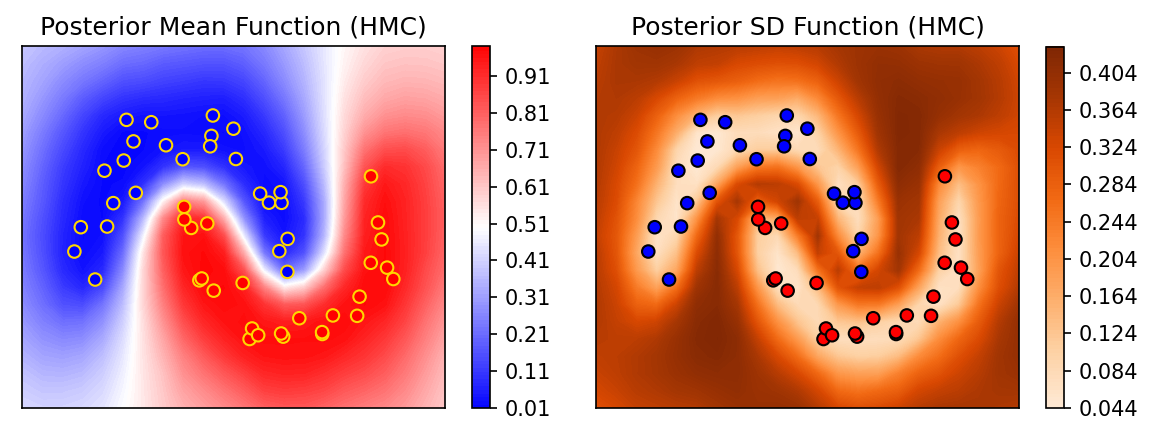

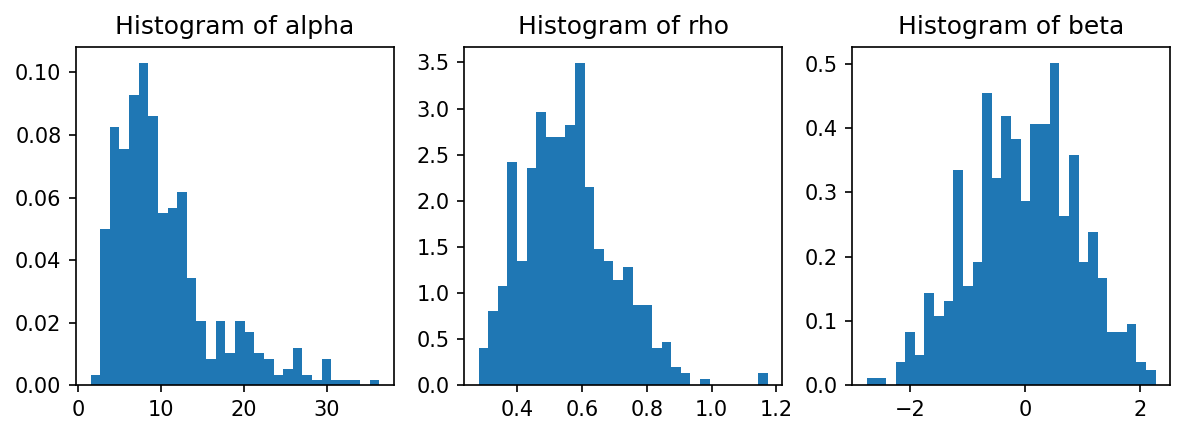

In [208]:
plot_uq(hmc_fit, X, y, 500, "HMC", eps=0.5)

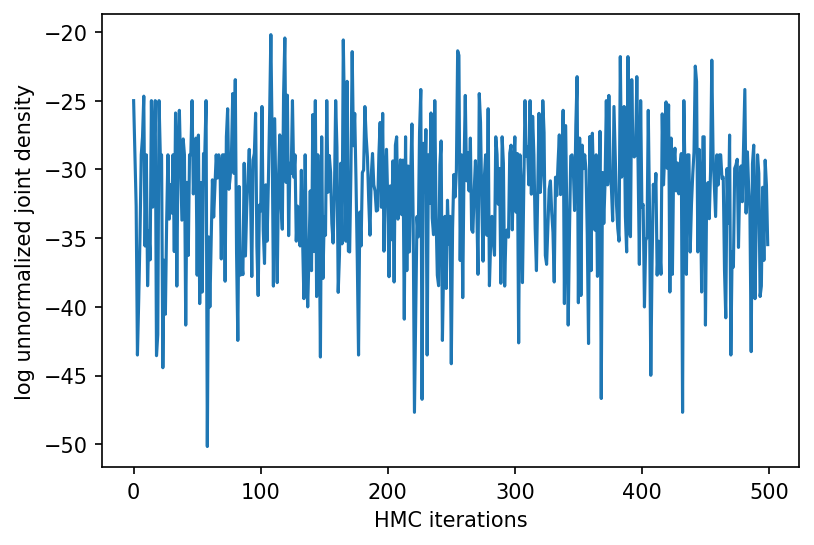

In [204]:
plt.plot(hmc_fit['lp__'])
plt.xlabel('HMC iterations')
plt.ylabel('log unnormalized joint density');

In [157]:
%%time

# Fit via NUTS.
nuts_fit = sm.sampling(data=stan_data, iter=1000, warmup=500, thin=1,
                       seed=1, algorithm='NUTS', chains=1)

CPU times: user 4.26 s, sys: 16.5 ms, total: 4.28 s
Wall time: 4.25 s


100%|██████████| 200/200 [00:01<00:00, 146.97it/s]


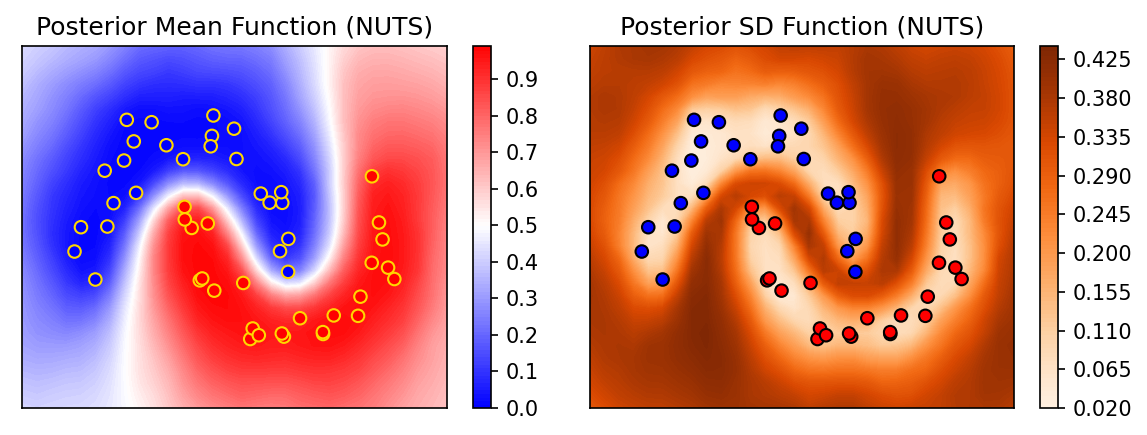

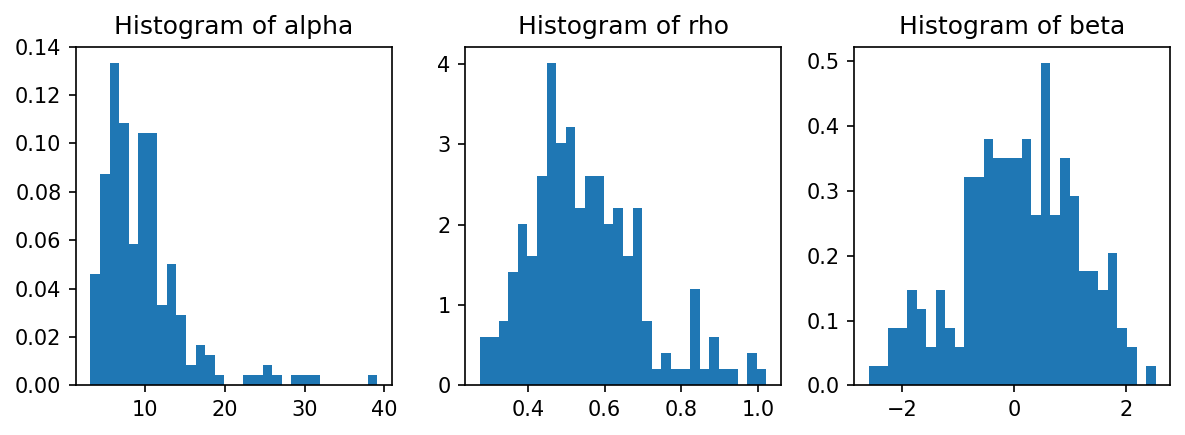

In [158]:
plot_uq(nuts_fit, X, y, 500, "NUTS", eps=0.5)

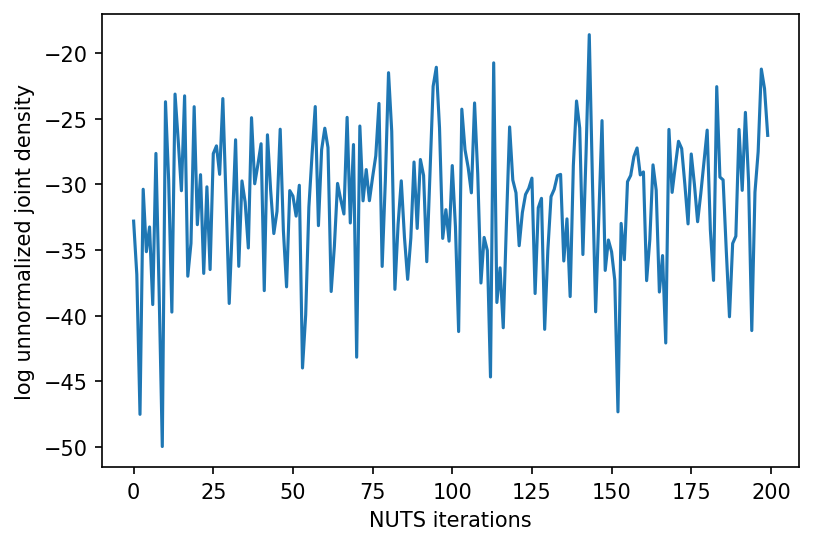

In [159]:
plt.plot(nuts_fit['lp__'])
plt.xlabel('NUTS iterations')
plt.ylabel('log unnormalized joint density');

In [205]:
# nuts_fit.get_sampler_params()[0]['stepsize__'][-1]

0.13943111245757375